In [214]:
import gudhi
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.ao.nn.quantized.functional import threshold
from tqdm import tqdm_pandas
from traffic.core import Flight

from functions.data_loading import get_filtered_data_range, get_data_range, get_flight_persistence, get_removed_outliers
from functions.data_filtering import complete_flight_filter
from functions.data_filtering import filter_by_bools, filter_flights

from datetime import datetime
import pickle

In [215]:
origin = "amsterdam"
destination = "heathrow"

unfiltered_flights, file_name = get_data_range(origin, destination, datetime(year=2023, month=1, day=1), datetime(year=2023, month=2, day=1))
filtered_flights, file_name = get_filtered_data_range(unfiltered_flights, file_name, complete_flight_filter(origin, destination, 0.75)) 
del unfiltered_flights
#persistences, file_name = get_flight_persistence(filtered_flights, file_name)

In [216]:
def build_sublevelset_filtration(Y):
    """
    Y: array-like
        Array of function values
    """
    st = gudhi.SimplexTree()
    for i in range(len(Y)):
        # 0-simplices
        st.insert([i], filtration=Y.iloc[i])

        if i < len(Y) - 1:
            # 1-simplices
            st.insert([i, i + 1], filtration=max(Y.iloc[i], Y.iloc[i + 1]))

    return st

In [217]:
def remove_spikes_iterative(altitude, threshold=250):
    # Start with an empty list for cleaned data
    cleaned = []
    
    # Iterate through the altitude data
    for i, value in enumerate(altitude):
        if pd.isna(value):
            # If the current value is NA, replace it with the last valid value or 0 if it's the first
            cleaned.append(cleaned[-1] if cleaned else 0)
        elif i == 0:
            # Always add the first value
            cleaned.append(value)
        else:
            # Compare with the last valid value
            if abs(value - cleaned[-1]) <= threshold:
                cleaned.append(value)
            else:
                # If it doesn't fit, replace with the last valid value
                cleaned.append(cleaned[-1])
    
    # Return as a pandas Series (if needed)
    return pd.Series(cleaned)

In [218]:
def get_sublevelset_filtration(flight: Flight):
    data = flight.data
    data = pd.DataFrame(data={"geoaltitude":list(data["geoaltitude"])},
                        index=pd.DatetimeIndex(data["timestamp"])).dropna()
    data = data["geoaltitude"].astype("float32").interpolate("time")
    data = remove_spikes_iterative(data)

    st = build_sublevelset_filtration(data)
    st.persistence()
    return st

In [219]:
from tqdm import tqdm
trees = []

for f in tqdm(filtered_flights):
    trees.append(get_sublevelset_filtration(f))

100%|██████████| 470/470 [00:16<00:00, 29.00it/s]


In [220]:
condensed_distance_matrix = []
for i in tqdm(range(len(trees))):
    for j in range(i+1, len(trees)):
        pers_i = trees[i].persistence_intervals_in_dimension(0)
        pers_j = trees[j].persistence_intervals_in_dimension(0)
        dist = gudhi.bottleneck_distance(np.array(pers_i), np.array(pers_j), 0.0001)
        condensed_distance_matrix.append(dist)

100%|██████████| 470/470 [00:41<00:00, 11.21it/s]


In [221]:
with open("condensed_distance_matrix.pkl", "wb") as f:
    pickle.dump(condensed_distance_matrix, f)

In [222]:
with open("condensed_distance_matrix.pkl", "rb") as f:
    condensed_distance_matrix = pickle.load(f)

In [223]:
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
import sys
sys.setrecursionlimit(10000)

Z = linkage(condensed_distance_matrix, "complete")

#fig = plt.figure(figsize=(100, 10))
#dn = dendrogram(Z)

#clustering = fcluster(Z, t=2, criterion='inconsistent', depth=3)
clustering = fcluster(Z, t=5, criterion='maxclust', depth=2)


In [224]:
for i in range(1, len(np.unique(clustering))+1):
    print(f"{i}: {sum(clustering == i)}")

1: 38
2: 13
3: 3
4: 415
5: 1


In [245]:
from traffic.core import Traffic

bool_array = clustering == 2

loopy_flight_cluster = filter_flights(filter_by_bools(bool_array), filtered_flights)
loopy_flight_cluster_pers = list(filter(filter_by_bools(bool_array), trees))
print(len(loopy_flight_cluster))

13


In [260]:
i = 12
data = loopy_flight_cluster[i].data["geoaltitude"]
x_values = [x / len(data) for x in range(len(data))]
plt.plot(x_values, remove_spikes_iterative(data))

IndexError: list index out of range

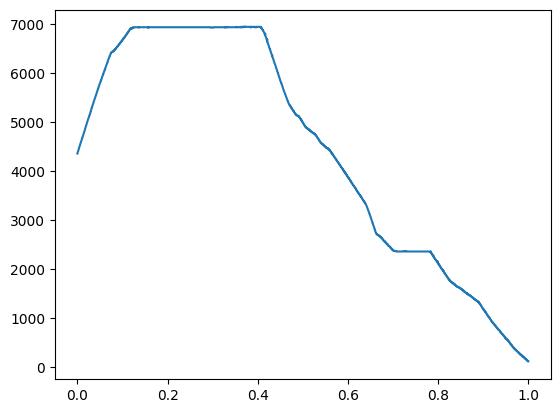

In [238]:
data = loopy_flight_cluster[i].data["geoaltitude"]
x_values = [x / len(data) for x in range(len(data))]
plt.plot(x_values, data, 100)